Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [10]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [13]:
#Retrieve number of images present in train dataset and test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239

118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## train dataset 
## Using seed=123 
## resize images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.

Using 1792 files for training.


In [16]:
## Validation dataset here
## Using seed=123 
## resize images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.

Using 447 files for validation.


In [17]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
Visualize one instance of all the nine classes present in the dataset

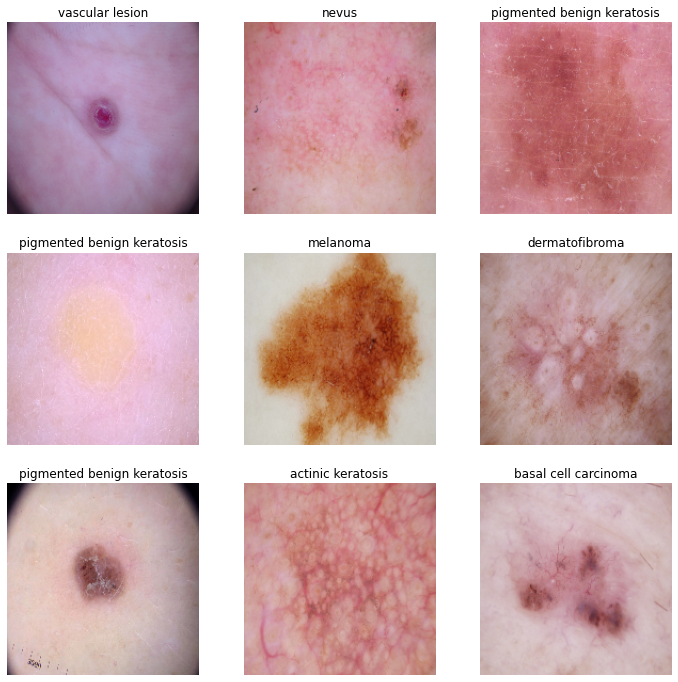

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.imshow(images[i].numpy().astype("uint8"))


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

### Model 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset.

In [20]:
tot_classes = 9

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [21]:
### Choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
# View the summary of all layers
model1.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 rescaling (Rescaling)       (None, 180, 180, 3)       0         

                                                                 

 conv2d (Conv2D)             (None, 180, 180, 16)      448       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      

                                                                 

 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         

 2D)                                                             

                                                                 

 conv2d_2 (Conv2D)           (None, 45, 

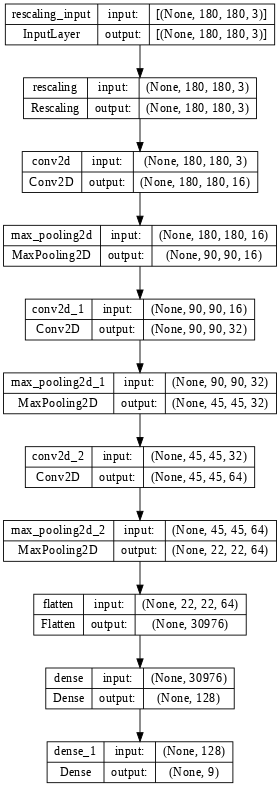

In [23]:
tf.keras.utils.plot_model(model1, show_shapes=True, dpi=64)

### Train the model


In [24]:
epochs = 20

history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20

56/56 [==============================] - 329s 1s/step - loss: 1.9742 - accuracy: 0.2550 - val_loss: 1.6943 - val_accuracy: 0.4385

Epoch 2/20

56/56 [==============================] - 1s 25ms/step - loss: 1.5641 - accuracy: 0.4408 - val_loss: 1.4514 - val_accuracy: 0.5168

Epoch 3/20

56/56 [==============================] - 1s 24ms/step - loss: 1.4356 - accuracy: 0.4944 - val_loss: 1.4733 - val_accuracy: 0.5056

Epoch 4/20

56/56 [==============================] - 1s 24ms/step - loss: 1.3519 - accuracy: 0.5296 - val_loss: 1.4850 - val_accuracy: 0.4765

Epoch 5/20

56/56 [==============================] - 1s 24ms/step - loss: 1.2318 - accuracy: 0.5631 - val_loss: 1.3670 - val_accuracy: 0.5682

Epoch 6/20

56/56 [==============================] - 1s 24ms/step - loss: 1.1887 - accuracy: 0.5971 - val_loss: 1.3714 - val_accuracy: 0.5436

Epoch 7/20

56/56 [==============================] - 1s 24ms/step - loss: 1.1101 - accuracy: 0.6161 - val_loss: 1.5938 - val_accuracy: 0.4966


### Visualizing training results

In [25]:
## Define function to visualize results
def results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  

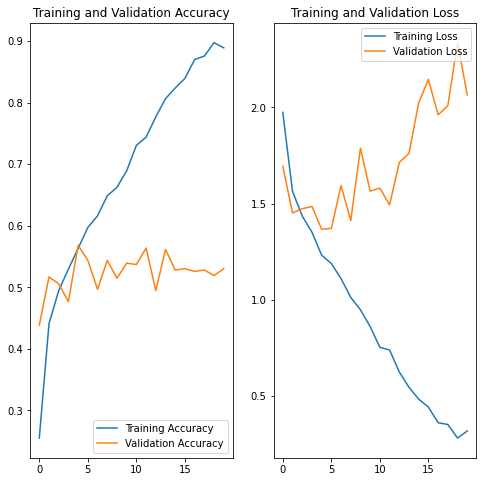

In [26]:
results(history)

### **Findings from Model1**
From the graph we can see training accuracy is very high as compared to validation accuracy. We can also see difference in loss functions in training and validation data around 19th and 20th epochs. This is a clear case of overfitting where model has learned too much from training dataset and it is not able to perform well on the validation dataset.
  - **Training Accuracy:** 88.90
  - **Validation Accuracy:** 53.02

In [27]:
# Choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

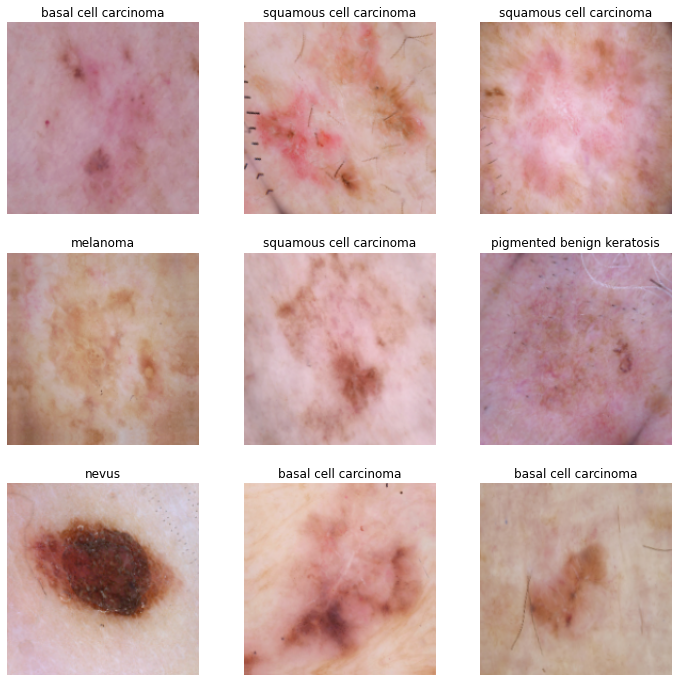

In [28]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

  

### Create the model, compile and train the model
### Model 2

In [30]:
## We can use Dropout layer as there is an evidence of overfitting in our findings

model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])

### Compiling the model

In [31]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
epochs = 20

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20

56/56 [==============================] - 3s 43ms/step - loss: 2.0217 - accuracy: 0.2584 - val_loss: 1.7590 - val_accuracy: 0.3043

Epoch 2/20

56/56 [==============================] - 2s 40ms/step - loss: 1.6425 - accuracy: 0.4068 - val_loss: 1.4714 - val_accuracy: 0.5213

Epoch 3/20

56/56 [==============================] - 2s 40ms/step - loss: 1.4998 - accuracy: 0.4559 - val_loss: 1.4843 - val_accuracy: 0.4765

Epoch 4/20

56/56 [==============================] - 2s 39ms/step - loss: 1.4300 - accuracy: 0.4944 - val_loss: 1.3660 - val_accuracy: 0.5280

Epoch 5/20

56/56 [==============================] - 2s 40ms/step - loss: 1.3302 - accuracy: 0.5234 - val_loss: 1.4832 - val_accuracy: 0.4989

Epoch 6/20

56/56 [==============================] - 2s 40ms/step - loss: 1.3277 - accuracy: 0.5296 - val_loss: 1.3275 - val_accuracy: 0.5213

Epoch 7/20

56/56 [==============================] - 2s 39ms/step - loss: 1.2682 - accuracy: 0.5374 - val_loss: 1.3715 - val_accuracy: 0.5280


### Visualizing the results

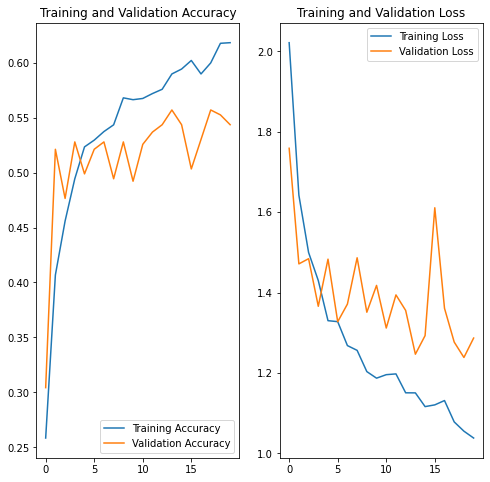

In [33]:
results(history)


#### **Findings from Model 2**
Accuracy of trainings has not improved as compared to base model but gap between training accuracy and validation accuracy is reduced. Also validation accuracy is increased slightly compared to base model. Gap between loss of training and validation is also reduced. And we observe that overfitting issue has been reduced due to data augmentation.
- **Training Accuracy:** 61.83
- **Validation Accuracy:** 54.36

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

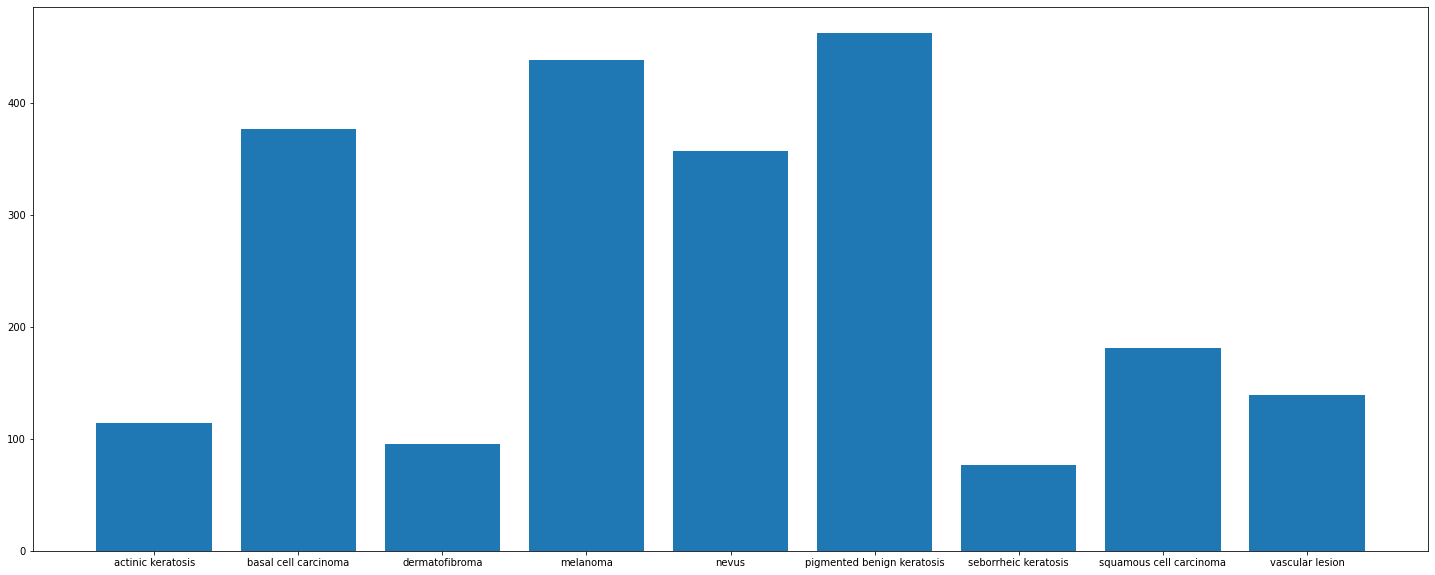

In [37]:
#plot number of images in each Class
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings from graph
#### - Which class has the least number of samples?
Seborrheic keratosi class has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign keratosis classes dominate the data in terms proportionate number of samples.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/










To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7680CD550>: 100%|██████████| 500/500 [00:23<00:00, 20.88 Samples/s]


Initialised with 376 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA76809EF40>: 100%|██████████| 500/500 [00:24<00:00, 20.19 Samples/s]


Initialised with 95 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA76A37C490>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 438 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA76A33CA90>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 357 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA7821B5AC0>: 100%|██████████| 500/500 [01:16<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA76B1B3700>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 77 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA76A25CC40>: 100%|██████████| 500/500 [00:40<00:00, 12.31 Samples/s]


Initialised with 181 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA7E4431E80>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Initialised with 139 image(s) found.

Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA76A38AA90>: 100%|██████████| 500/500 [00:17<00:00, 28.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

<BarContainer object of 9 artists>

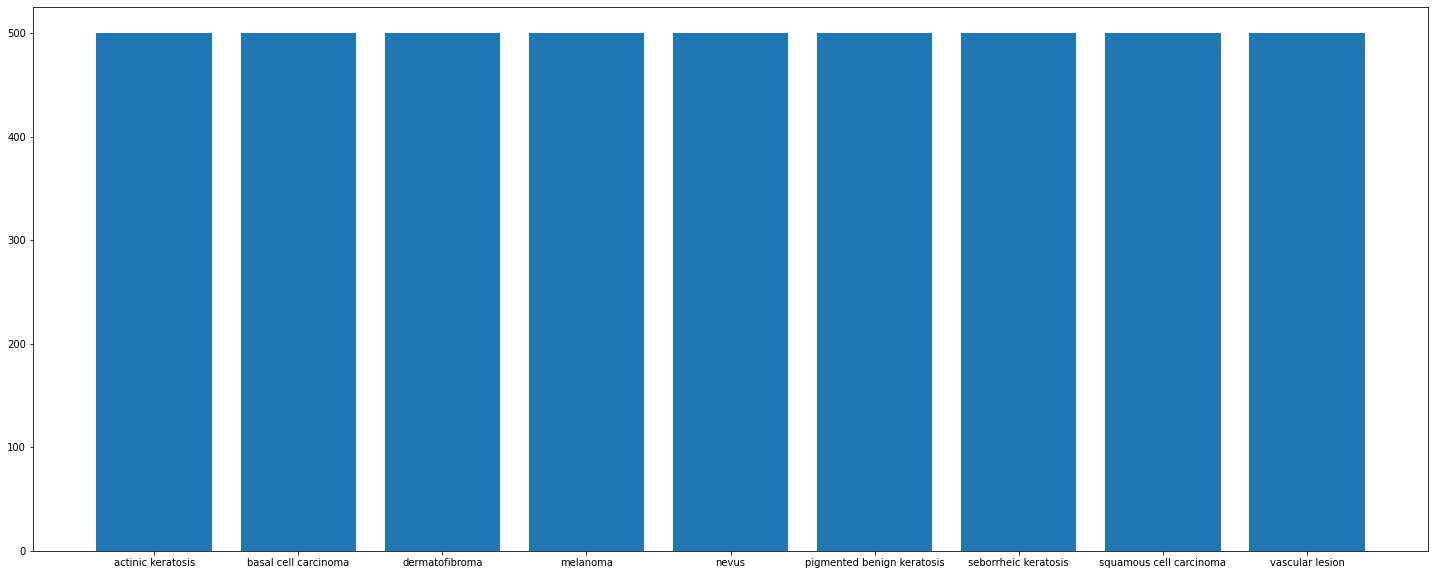

In [41]:
# Check the distribution of data again. 
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'*/output/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [42]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_be13feea-152c-458d-a123-af0a1d1ddb20.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032240.jpg_07b0dfe2-f5a8-42a4-bb8f-23f81585afc4.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030956.jpg_da1a2fac-d739-4e1f-a859-f85e94ec6f0a.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_34091e02-93b2-4eee-867f-efb6e2cbf537.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [45]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [47]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor
#### Model 3

In [58]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [59]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.

Using 5392 files for training.


#### Create a validation dataset

In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.

Using 1347 files for validation.


#### Create your model with normalization

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(tot_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [62]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [64]:
epochs = 30

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30

169/169 [==============================] - 10s 59ms/step - loss: 1.8316 - accuracy: 0.3008 - val_loss: 1.6019 - val_accuracy: 0.4172

Epoch 2/30

169/169 [==============================] - 4s 25ms/step - loss: 1.4511 - accuracy: 0.4492 - val_loss: 1.3692 - val_accuracy: 0.4529

Epoch 3/30

169/169 [==============================] - 4s 24ms/step - loss: 1.2731 - accuracy: 0.5284 - val_loss: 1.2072 - val_accuracy: 0.5605

Epoch 4/30

169/169 [==============================] - 4s 24ms/step - loss: 1.1761 - accuracy: 0.5660 - val_loss: 1.1348 - val_accuracy: 0.5887

Epoch 5/30

169/169 [==============================] - 4s 24ms/step - loss: 1.0171 - accuracy: 0.6235 - val_loss: 1.0809 - val_accuracy: 0.6028

Epoch 6/30

169/169 [==============================] - 4s 24ms/step - loss: 0.9007 - accuracy: 0.6643 - val_loss: 1.0822 - val_accuracy: 0.5976

Epoch 7/30

169/169 [==============================] - 4s 24ms/step - loss: 0.7986 - accuracy: 0.7086 - val_loss: 0.8869 - val_ac

#### Visualize the model results

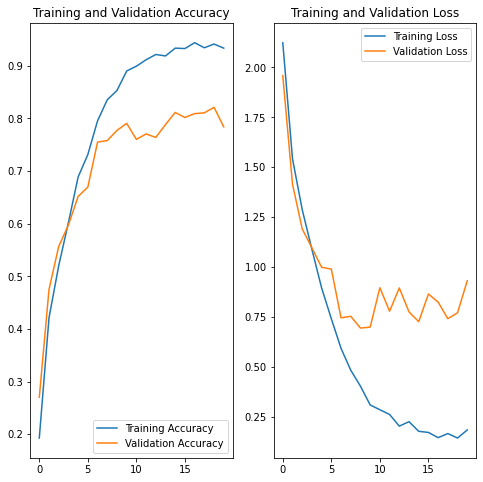

In [57]:
results(history)

#### **Findings from Model 3**

Accuracy of training and validation has been increased significantly due to augmentation and class imbalnce handling. The model is not overfitting. This model can be used as final model.

- **Training Accuracy:** 94.12
- **Validation Accuracy:** 83